# WISONet δD Retrievals
This notebook demonstrates how averaging kernels and a priori values affect satellite δD retrievals.


In [117]:
!curl -L "https://rice.box.com/shared/static/bcoy3ob0dme3umpurqmf0p6o48bznkj1" -o SWING3_2006_subset.nc
!curl -L "https://rice.box.com/shared/static/uuy9m15qc1p7s4wm1yrzfzxc6knx7hzw" -o TES_monthly_5deg_strict.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 12.7M  100 12.7M    0     0  6217k      0  0:00:02  0:00:02 --:--:-- 51.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      9      0 --:--:--  0:00:01 --:--:-- 10000
100 3095M  100 3095M    0     0  40.6M      0  0:01:16  0:01:16 --:--:-- 41.2M


In [131]:
!ls -lh


total 3.1G
drwxr-xr-x 1 root root 4.0K Jun 11 13:37 sample_data
-rw-r--r-- 1 root root  13M Jun 12 21:33 SWING3_2006_subset.nc
-rw-r--r-- 1 root root 3.1G Jun 12 21:35 TES_monthly_5deg_strict.nc


In [152]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interact, fixed
# import warnings

@interact(month=widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month'))
def update_plot(month):
    m = month - 1

    # === Construct last day of month string ===
    last_day = calendar.monthrange(2006,month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    # === Load SWING3 ===
    ds = xr.open_dataset("SWING3_2006_subset.nc")
    lon = ds['lon'].values
    lat = ds['lat'].values
    p = ds['p'].values
    month = ds['month'].values
    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)

    # === Mask out fill values ===
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    # === Subset latitude range [-10, 10] ===
    lat_mask = (lat >= 20) & (lat <= 40)
    dD_eq = dD[m, :, lat_mask, :]  # [month, level, lat, lon]
    q_eq  = q[m, :, lat_mask, :]

    # === Average over lon and lat ===
    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    # === Constants ===
    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528

    # === Convert q from mass to VMR ===
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    # === Load TES ===
    sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
    tes_lat = sat['lat'].values
    tes_lon = sat['lon'].values
    tes_p = sat['level'].values
    tes_time = sat['time'].values

    # === Time matching ===
    base_date = datetime(2000, 1, 1)
    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    # === Spatial subset: Equatorial Pacific [-10,10] ===
    ilat_tes = np.where((tes_lat >= 20) & (tes_lat <= 40))[0]
    ilon_tes = np.arange(len(tes_lon))

    HDO_ret = sat['HDO_vmr'].values
    HDO_a   = sat['HDO_ConstraintVector'].values
    AK      = sat['AK_HDO'].values

    lat_mask = (tes_lat >= -10) & (tes_lat <= 10)
    HDO_ret = HDO_ret[t_tes, :, lat_mask, :]
    HDO_a   = HDO_a[t_tes, :, lat_mask, :]
    AK      = AK[t_tes, :, :, lat_mask, :]

    # === Mask invalid values ===
    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    # === Average over lat and lon ===
    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

    # === Interpolate model to TES pressure ===
    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])

    # === Apply AK ===
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)

    # === Plot ===
    plt.figure()
    plt.semilogx(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
    plt.semilogx(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    plt.semilogx(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    plt.semilogx(HDO_recon, tes_p, 'm-.', label='AK-applied')

    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model (10S-10N, {user_date_str})')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.ylim(850, 250)  # Inverted y-axis: top = 250, bottom = 850
    plt.xlim(1e-7, 1e-5)  # Inverted y-axis: top = 250, bottom = 850
    plt.show()


interactive(children=(IntSlider(value=1, description='Month', max=12, min=1), Output()), _dom_classes=('widget…

TES matched date index: 22
TES matched time value: 2006-08-31T00:00:00.000000000


In [155]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, VBox, HBox
import matplotlib.colors as mcolors

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values

tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Widget Controls ===
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
lat_slider = widgets.FloatSlider(min=-30, max=30, step=5, value=30, description='Lat Center')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')

# === Plot Function ===
def update_plot(month, lat_center, log_x, step_view, show_ak):
    m = month - 1
    lat_band = 10

    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan
    lat_mask = (lat >= lat_center - lat_band/2) & (lat <= lat_center + lat_band/2)
    dD_eq = dD[m, :, lat_mask, :]
    q_eq  = q[m, :, lat_mask, :]
    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_mask = (tes_lat >= lat_center - lat_band/2) & (tes_lat <= lat_center + lat_band/2)
    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_mask, :]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_mask, :]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_mask, :]

    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)

    plt.figure(figsize=(6, 8))
    if step_view == 'A priori only':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        plt.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        plt.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        plt.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        plt.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')

    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model ({lat_center-5:.0f} to {lat_center+5:.0f}°N, {user_date_str})')
    plt.ylim(850, 250)
    if log_x:
        plt.xscale('log')
        plt.xlim(1e-7, 1e-5)
    else:
        plt.xlim(0, 4e-6)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

    if show_ak:
        plt.figure(figsize=(5, 5))
        pcm = plt.pcolormesh(tes_p, tes_p, AK_avg.T, shading='nearest', cmap='viridis', norm=mcolors.Normalize(0, 1))
        plt.gca().invert_yaxis()
        plt.xlabel('True Level [hPa]')
        plt.ylabel('Retrieved Level [hPa]')
        plt.title('TES Averaging Kernel Matrix')
        plt.colorbar(pcm, label='AK Value')
        plt.grid(True)
        plt.show()

# === Combine Widgets ===
ui = VBox([HBox([month_slider, lat_slider]), HBox([log_toggle, step_dropdown, ak_toggle])])
out = interactive_output(update_plot, {
    'month': month_slider,
    'lat_center': lat_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle
})

display(ui, out)


Output()

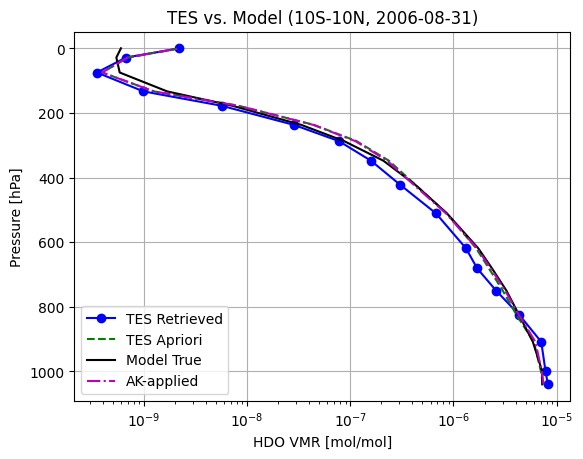

np.int64(22)

In [144]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar

# === User-defined month ===
user_month = 8  # CHANGE THIS (1 = January, 12 = December)
m = user_month - 1  # 0-based index for SWING3

# === Construct last day of month string ===
last_day = calendar.monthrange(2006, user_month)[1]
user_date_str = f'2006-{user_month:02d}-{last_day}'
target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

# === Load SWING3 ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values
month = ds['month'].values
dD = ds['dD'].values.astype(float)
q = ds['q'].values.astype(float)

# === Mask out fill values ===
dD[dD == -999] = np.nan
q[q == -999] = np.nan

# === Subset latitude range [-10, 10] ===
lat_mask = (lat >= -10) & (lat <= 10)
dD_eq = dD[m, :, lat_mask, :]  # [month, level, lat, lon]
q_eq  = q[m, :, lat_mask, :]

# === Average over lon and lat ===
dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

# === Constants ===
Rvsmow = 3.1152e-4
M_air = 28.9647
M_H2O = 18.01528

# === Convert q from mass to VMR ===
q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

# === Load TES ===
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Time matching ===
base_date = datetime(2000, 1, 1)
if np.issubdtype(tes_time.dtype, np.datetime64):
    t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
else:
    target_days = (target_date - base_date).days
    t_tes = np.argmin(np.abs(tes_time - target_days))

# === Spatial subset: Equatorial Pacific [-10,10] ===
ilat_tes = np.where((tes_lat >= -10) & (tes_lat <= 10))[0]
ilon_tes = np.arange(len(tes_lon))

HDO_ret = sat['HDO_vmr'].values
HDO_a   = sat['HDO_ConstraintVector'].values
AK      = sat['AK_HDO'].values

lat_mask = (tes_lat >= -10) & (tes_lat <= 10)
HDO_ret = HDO_ret[t_tes, :, lat_mask, :]
HDO_a   = HDO_a[t_tes, :, lat_mask, :]
AK      = AK[t_tes, :, :, lat_mask, :]

# === Mask invalid values ===
HDO_ret[HDO_ret == -999] = np.nan
HDO_a[HDO_a == -999] = np.nan
AK[AK == -999] = np.nan

# === Average over lat and lon ===
HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

# === Interpolate model to TES pressure ===
HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])

# === Apply AK ===
ln_true = np.log(HDO_vmr1_interp)
ln_apriori = np.log(HDO_a_avg)
ln_smoothed = ln_apriori + AK_avg @ (ln_true - ln_apriori)
HDO_recon = np.exp(ln_smoothed)

# === Plot ===
plt.figure()
plt.semilogx(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
plt.semilogx(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
plt.semilogx(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
plt.semilogx(HDO_recon, tes_p, 'm-.', label='AK-applied')

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title(f'TES vs. Model (10S-10N, {user_date_str})')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

t_tes

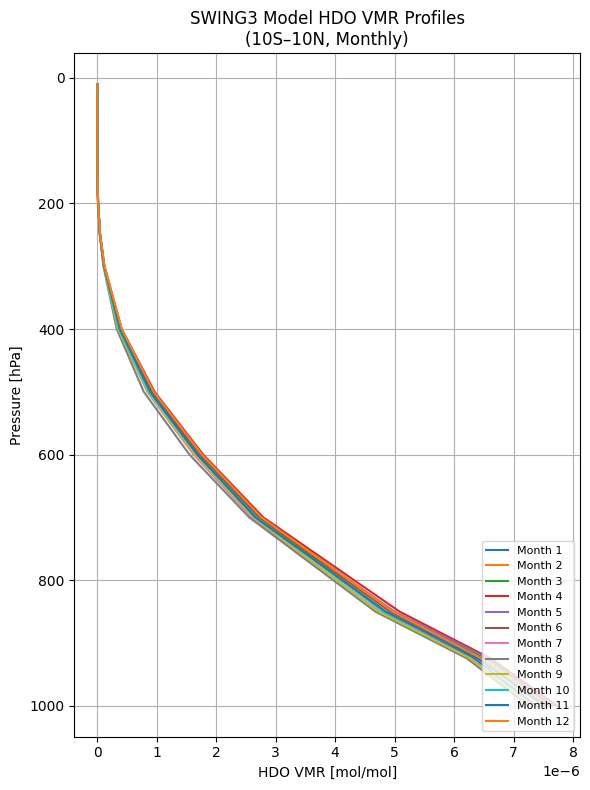

In [140]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# === Load SWING3 ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values
dD = ds['dD'].values.astype(float)
q = ds['q'].values.astype(float)

# === Mask fill values ===
dD[dD == -999] = np.nan
q[q == -999] = np.nan

# === Constants ===
Rvsmow = 3.1152e-4
M_air = 28.9647
M_H2O = 18.01528

# === Subset latitude range [-10, 10] and plot all months
lat_mask = (lat >= -10) & (lat <= 10)

plt.figure(figsize=(6, 8))

for m in range(dD.shape[0]):  # assuming shape is (month, level, lat, lon)
    dD_eq = dD[m, :, lat_mask, :]
    q_eq  = q[m, :, lat_mask, :]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean  = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    plt.plot(HDO_vmr1, p, label=f'Month {m+1}')

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('SWING3 Model HDO VMR Profiles\n(10S–10N, Monthly)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


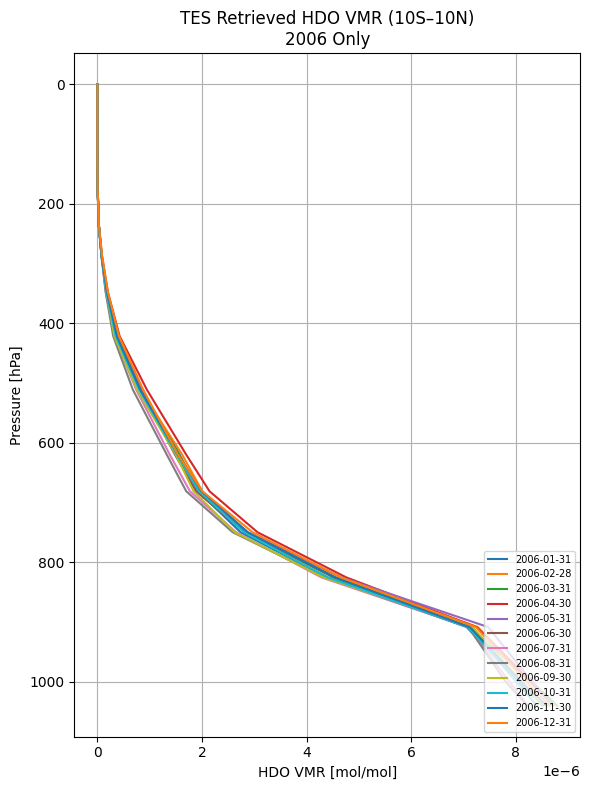

In [143]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# === Load TES ===
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p   = sat['level'].values
tes_time = sat['time'].values

# === Identify indices for 2006 only
if np.issubdtype(tes_time.dtype, np.datetime64):
    time_mask = (tes_time >= np.datetime64('2006-01-01')) & (tes_time <= np.datetime64('2006-12-31'))
else:
    base_date = datetime(2000, 1, 1)
    date_list = [base_date + np.timedelta64(int(t), 'D') for t in tes_time]
    time_mask = [(d.year == 2006) for d in date_list]

valid_indices = np.where(time_mask)[0]

# === Spatial mask
lat_mask = (tes_lat >= -10) & (tes_lat <= 10)

plt.figure(figsize=(6, 8))

for t_tes in valid_indices:
    user_date_str = str(np.datetime_as_string(tes_time[t_tes], unit='D')) if np.issubdtype(tes_time.dtype, np.datetime64) else f"time index {t_tes}"

    HDO_ret = sat['HDO_vmr'].values[t_tes, :, lat_mask, :]
    HDO_ret[HDO_ret == -999] = np.nan
    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)

    plt.plot(HDO_ret_avg, tes_p, label=user_date_str)

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('TES Retrieved HDO VMR (10S–10N)\n2006 Only')
plt.legend(fontsize=7, loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
